In [17]:
import keras
from keras import backend as K
from keras.datasets import mnist
from keras import Model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy
from keras.utils import plot_model

import numpy as np

#sample
# input args : tesnsor
# output z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_logVar = args
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]  # shape int_shape?
    noise = K.random_normal(shape=(batch, dim ))
    return z_mean + K.exp( 0.5 * z_logVar) * noise

# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)
x_train = x_train.astype('float32') / 255   #？？？important but why？
x_test = x_test.astype('float32') / 255

input_dim = x_train.shape[1]
hidden1_size = 512
z_dim = 2

batch_size = 256
epochs = 50

#encoder
img_in = Input(shape = (input_dim, ), name = "encoder_input" )
hidden1 = Dense(hidden1_size, activation="relu", name = "encoder_hidden1")(img_in)
z_mean = Dense(z_dim, name = "z_mean")(hidden1)
z_logVar = Dense(z_dim, name = "z_logVar")(hidden1)

z_sampled = Lambda(sampling,output_shape=(z_dim, ), name = "z")([z_mean, z_logVar])

#decode
decoder_in = Input(shape= (z_dim,), name = "z_sampled" )
hidden2 = Dense(hidden1_size, activation="relu", name = "decoder_hindden")(decoder_in)
img_out = Dense(input_dim, activation="sigmoid", name = "output")(hidden2)

encoder = Model(img_in, [z_mean, z_logVar, z_sampled], name = "encoder")
decoder = Model(decoder_in, img_out, name = "decoder")
img_out = decoder(encoder(img_in)[2])
vae = Model(img_in, img_out, name = "VAE")

reconstruc_loss = binary_crossentropy(img_in, img_out)
reconstruc_loss *= input_dim
KL_loss = 1 + z_logVar - K.square(z_mean) - K.exp(z_logVar)
KL_loss =  K.sum(KL_loss, axis=-1)
KL_loss *= -0.5
loss =  reconstruc_loss #+ KL_loss 
loss = K.mean(loss)
vae.add_loss(loss)
vae.compile(optimizer = "adam")
vae.summary()
plot_model(vae, to_file = "vae.png", show_shapes=True)

vae.fit(x_train, epochs = epochs, batch_size = batch_size, validation_data= (x_test, None))
vae.save_weights('VAEZhiyuan.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 24us/step - loss: 204.8211 - val_loss: 178.6676
Epoch 2/50
60000/60000 [==============================] - 1s 14us/step - loss: 172.4591 - val_loss: 164.8214
Epoch 3/50
60000/60000 [==============================] - 1s 14us/step - loss: 162.8974 - val_loss: 160.2071
Epoch 4/50
60000/60000 

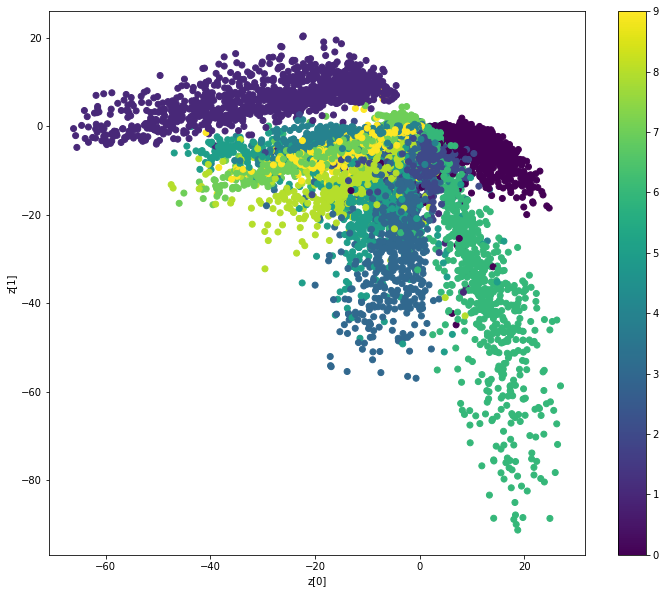

In [18]:
# plot part
import matplotlib.pyplot as plt
%matplotlib inline
z_mean, _, _ = encoder.predict(x_test)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


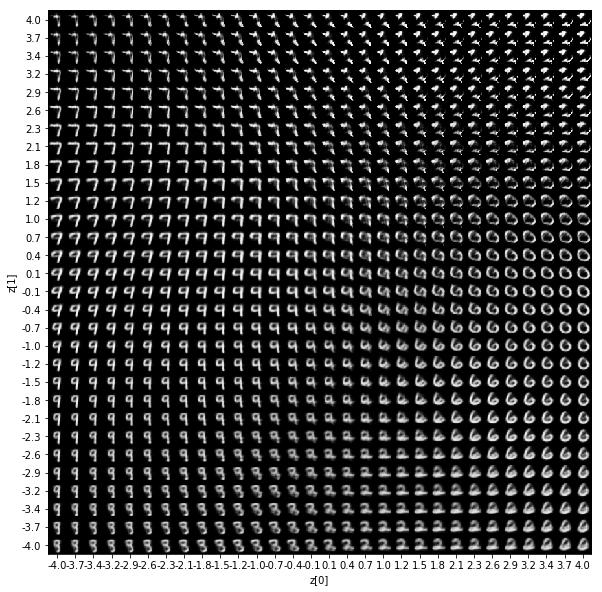

In [19]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.show()